In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/carlo/workspace/networkqit/')
import numpy as np
import pandas as pd
import scipy
import networkqit as nq
import operator
import matplotlib.pyplot as plt
from itertools import product
from networkqit.utils.visualization import step_callback, plot_spectral_entropy
from networkqit import graph_laplacian
import seaborn as sns
import multiprocessing
import warnings
from drawnow import drawnow, figure
# Set seaborn as matplotlib backend style
sns.set()
from os.path import expanduser
from bct import threshold_proportional, threshold_absolute
from scipy.linalg import eigvalsh
from scipy.stats import entropy
home = expanduser("~")
import bct
import sys

# Define the methods to create weighted correlation networks from factor model 

In [3]:
def factor_model(ci,T,eta,mu):
    N = len(ci) # number of nodes, length of membership vector
    # Initialize the observations vector a TxN matrix of NaNs
    Y = np.ones([T,N])*np.nan
    
    # Fill the identical observations in the maximally correlated subsets
    for c in np.unique(ci):
        i = np.where(ci==c)[0]
        Y[:,i] = np.kron(np.ones((1,(ci==c).sum())),np.random.randn(T,1))

    # Add local noise beta on each time-series
    Y += eta*np.random.randn(T,N)
        
    # Add global signal mu that correlates globally each time series
    Y += mu*np.kron(np.ones((1,N)),np.random.randn(T,1))

    from scipy.stats import zscore
    Y = zscore(Y)
    C = np.corrcoef(Y.T)
    return C

In [4]:
def brain_network(ci, T=150, local_noise=2, global_noise=4, gamma=10, density=0.1):
    C = np.triu(factor_model(ci,T,local_noise,global_noise),1)
    C += C.T
    C = C**gamma # soft thresholding
    C/=C.max()
    C = np.arctanh(C)
    C[np.isinf(C)]=0
    C = threshold_proportional(C,density) # keep a specific percentage of links
    return C

In [5]:
def reindex_membership(membership):
    """
    This function has the membership as input and output the membership
    where the communities number are ordered by the number of nodes in that community
    """
    ds = {}
    for u, v in enumerate(membership):
        if v not in ds.keys():
            ds[v] = []
        ds[v].append(u)

    S = dict(
        zip(range(0, len(ds)), sorted(ds.values(), key=len, reverse=True)))

    M = {}

    for u, vl in S.items():
        for v in vl:
            M[v] = u
    return list(M.values())

In [6]:
from scipy.io import loadmat
W=loadmat('/home/carlo/workspace/communityalg/data/GroupAverage_rsfMRI_matrix_unthr.mat')['RS_unthr']
ci = bct.community_louvain(bct.threshold_absolute(W,0.6))
ci = reindex_membership(ci[0])
[bounds,ixes] = bct.grid_communities(np.array(ci))

In [7]:
sns.set(font_scale=1.5)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in arctanh
  


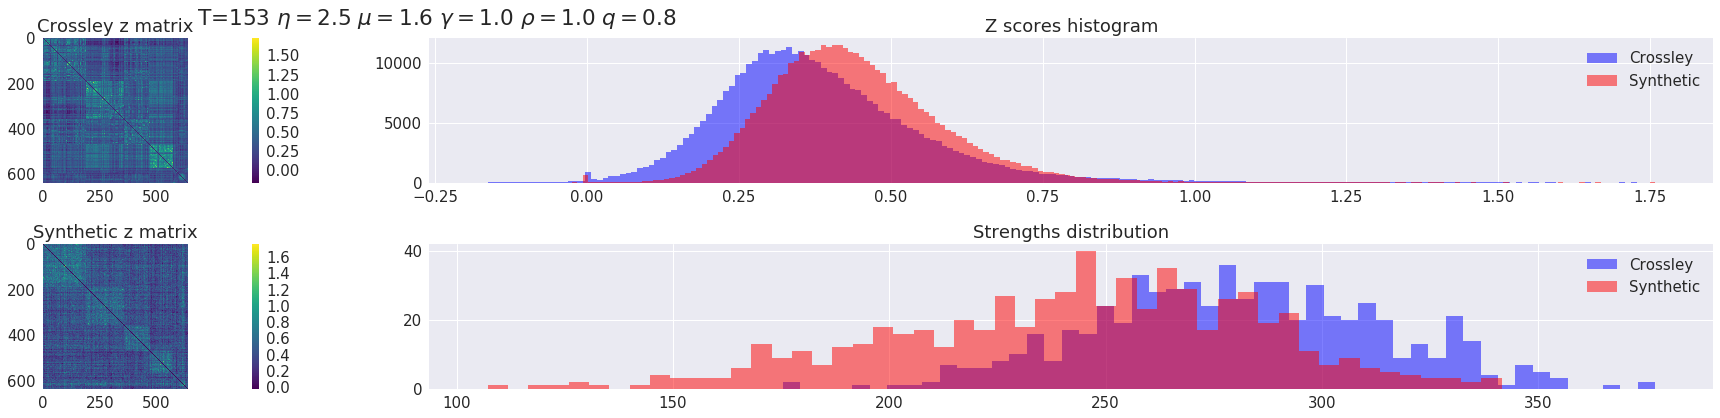

In [8]:
T,local_noise,global_noise,factor=153, 2.5, 1.6, 0.75
A = brain_network(ci=ci, T=T, local_noise=local_noise, global_noise=global_noise, gamma=1, density=1)*factor

fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(36,6))
#plt.suptitle('Networks from factor model local noise $\eta=2.2$ global noise $\mu=4$')
plt.suptitle('T=%d $\\eta=%.1f$ $\\mu=%.1f$ $\\gamma=%.1f$ $\\rho=%.1f$ $q=%.1f$' % (T,local_noise,global_noise,1,1,factor))
##### plot 0
h0 = ax[0,0].imshow(W[np.ix_(ixes,ixes)],cmap='viridis')
ax[0,0].grid(False)
ax[0,0].set_title('Crossley z matrix')
#### plot 1
h1 = ax[1,0].imshow(A[np.ix_(ixes,ixes)],cmap='viridis')
ax[1,0].grid(False)
ax[1,0].set_title('Synthetic z matrix')
##### plot 2
ax[0,1].hist(W.ravel(),200,alpha=0.5,color='b')
ax[0,1].grid(True)
ax[0,1].set_title('Z scores histogram')
ax[0,1].hist(A.flatten(),200,alpha=0.5,color='r')
ax[0,1].legend(['Crossley','Synthetic'])
plt.colorbar(h0,ax=ax[0,0])
plt.colorbar(h1,ax=ax[1,0])

### plot 3 degree distribution
ax[1,1].hist(A.sum(axis=0),50,alpha=0.5,color='b')
ax[1,1].hist(W.sum(axis=0),50,alpha=0.5,color='r')
ax[1,1].set_title('Strengths distribution')
ax[1,1].legend(['Crossley','Synthetic'])
plt.tight_layout()
plt.savefig('crossley_vs_synthetic.pdf',dpi=300,bbox_inches='tight')
plt.show()

## Study the spectral entropy as a function of the interlinks density

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in arctanh
  


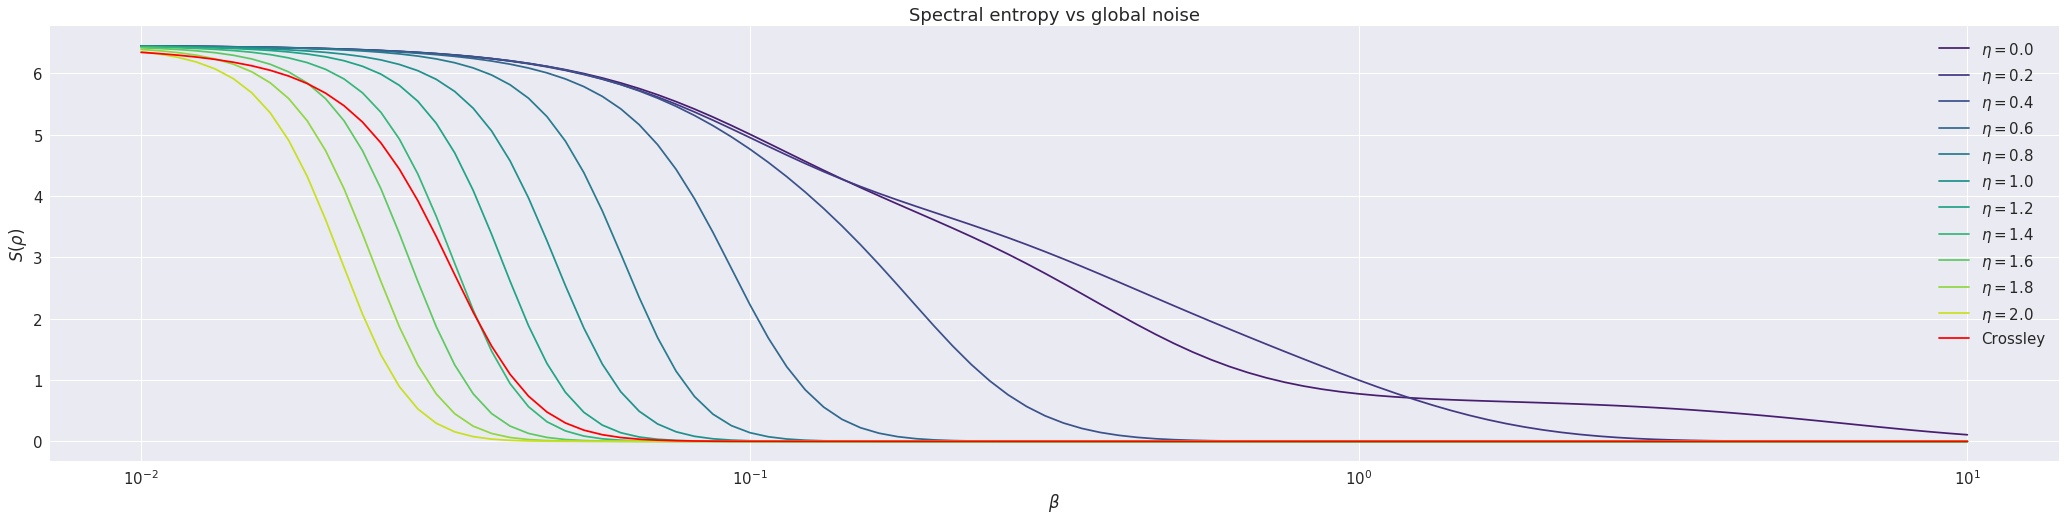

In [9]:
sns.set(font_scale=1.5)
#T,local_noise,global_noise,factor=200,2.5,1.5,0.8
beta_range=np.logspace(-2,1,100)
all_global_noise = np.linspace(0,2,11)
cmap = sns.color_palette('viridis',len(all_global_noise))
plt.figure(figsize=(36,8))
for i,g in enumerate(all_global_noise):
    A = np.array([ brain_network(ci=ci, T=200, local_noise=local_noise, global_noise=g, gamma=1, density=1)*factor for x in range(0,10)]).mean(axis=0)
    L = nq.graph_laplacian(A)
    plt.semilogx(beta_range,[nq.compute_vonneumann_entropy(L=L,beta=b) for b in beta_range],color=cmap[i])

plt.title('Spectral entropy vs global noise')
plt.semilogx(beta_range,[nq.compute_vonneumann_entropy(L=nq.graph_laplacian(W),beta=b) for b in beta_range],color='r')
plt.xlabel('$\\beta$')
plt.ylabel('$S(\\rho)$')
plt.legend(['$\\eta=%.1f$' % (g) for g in all_global_noise]+['Crossley'])
plt.savefig('spectral_entropy_synthetic_global_noise.pdf',dpi=300,bbox_inches='tight')
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in arctanh
  


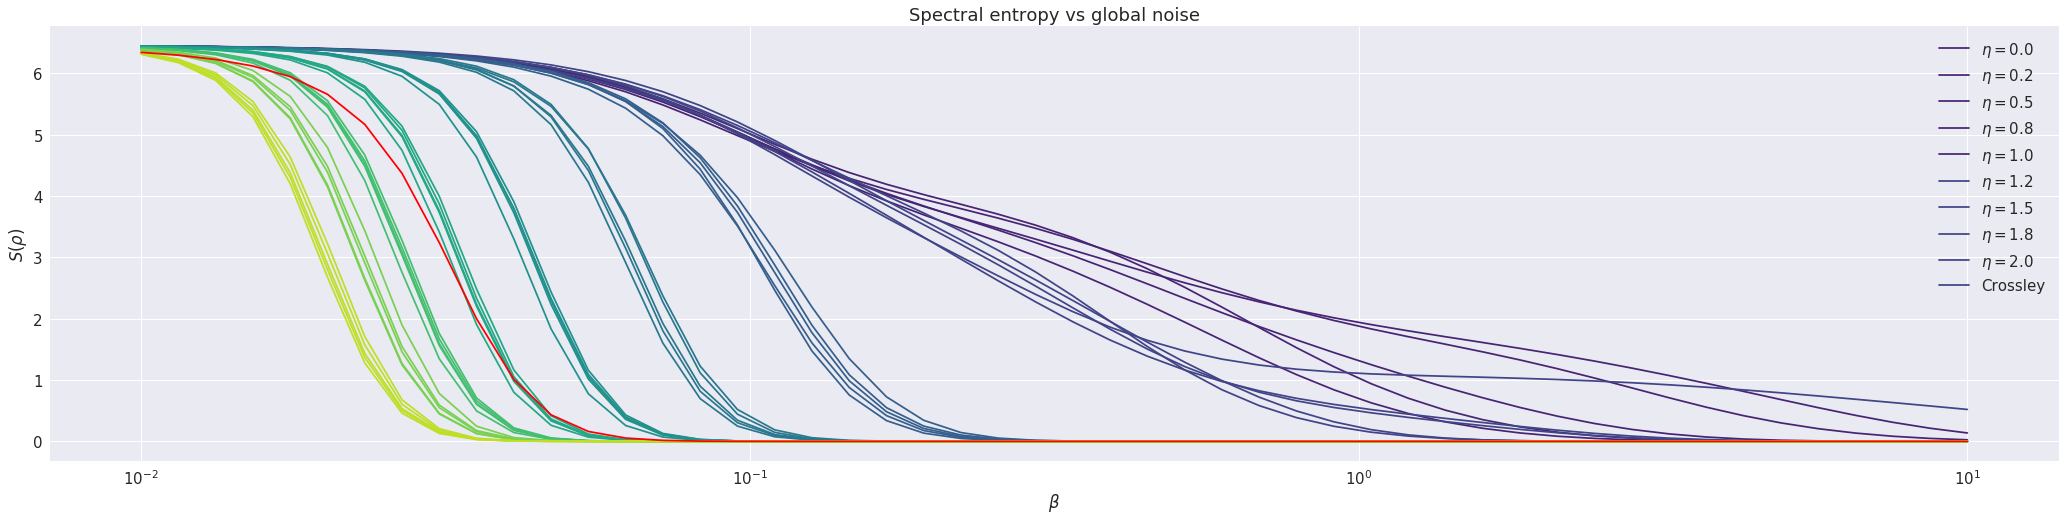

In [17]:
sns.set(font_scale=1.5)
#T,local_noise,global_noise,factor=200,2.5,1.5,0.8
beta_range=np.logspace(-2,1,50)
all_global_noise = np.linspace(0,2,9)
cmap = sns.color_palette('viridis',len(all_global_noise))
plt.figure(figsize=(36,8))
for i,g in enumerate(all_global_noise):
    for r in range(0,5):
        A = np.array([ brain_network(ci=ci, T=200, local_noise=local_noise, global_noise=g, gamma=1, density=1)*factor for x in range(0,10)]).mean(axis=0)
        L = nq.graph_laplacian(A)
        plt.semilogx(beta_range,[nq.compute_vonneumann_entropy(L=L,beta=b) for b in beta_range],color=cmap[i])

plt.title('Spectral entropy vs global noise')
plt.semilogx(beta_range,[nq.compute_vonneumann_entropy(L=nq.graph_laplacian(W),beta=b) for b in beta_range],color='r')
plt.xlabel('$\\beta$')
plt.ylabel('$S(\\rho)$')
plt.legend(['$\\eta=%.1f$' % (g) for g in all_global_noise]+['Crossley'])
plt.savefig('spectral_entropy_synthetic_global_noise.pdf',dpi=300,bbox_inches='tight')
plt.show()

# Effect of weight increase (soft thresholding)

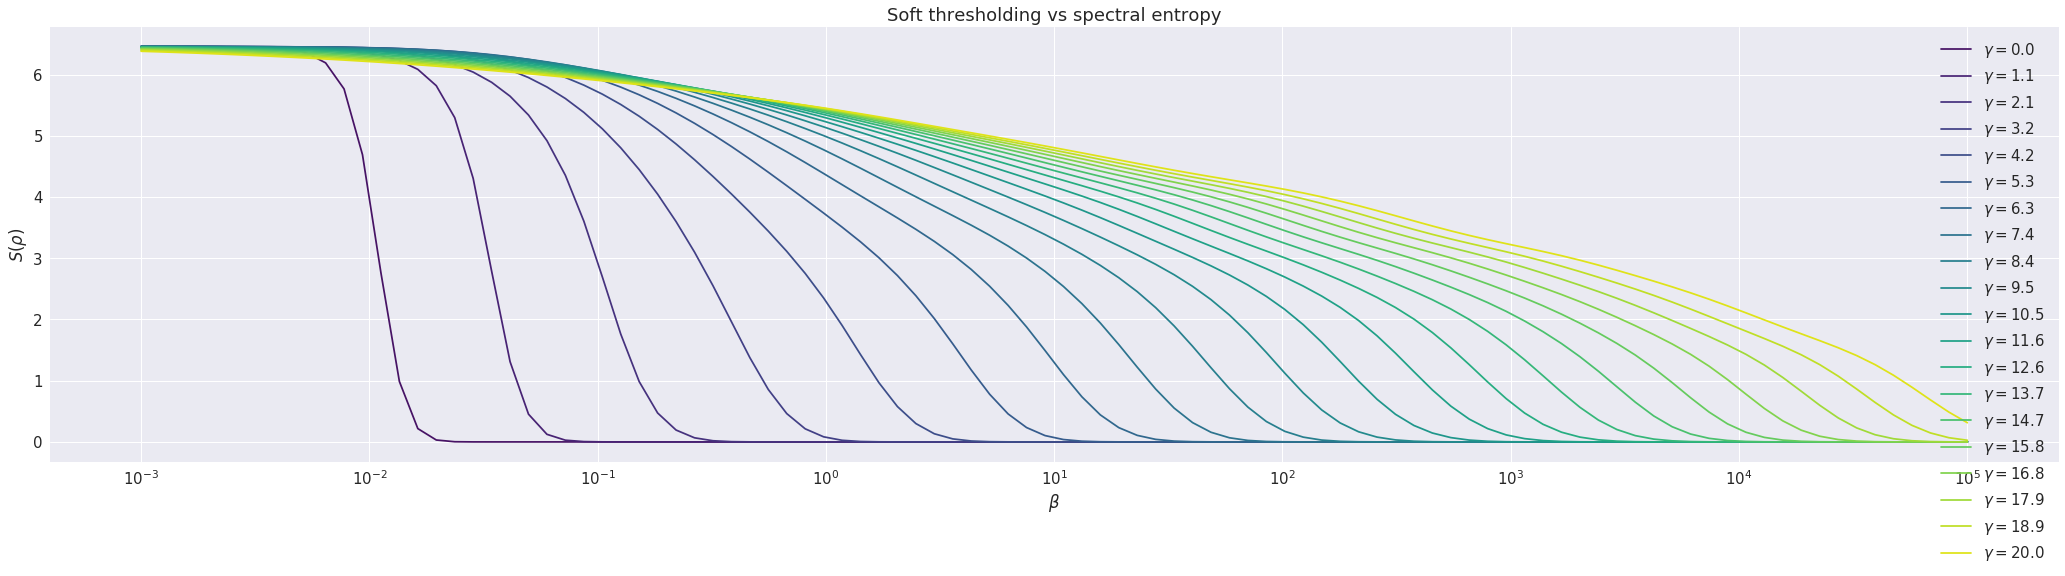

In [39]:
#T,local_noise,global_noise,factor=200,2.5,1.5,0.8
beta_range=np.logspace(-3,5,100)
plt.figure(figsize=(36,8))
allgamma = np.linspace(0,20,20)
cmap = sns.color_palette('viridis',len(allgamma))
plt.title('Soft thresholding vs spectral entropy')
for i,s in enumerate(allgamma):
    plt.semilogx(beta_range,[nq.compute_vonneumann_entropy(L=nq.graph_laplacian(threshold_absolute(W,0)**s),beta=b) for b in beta_range],color=cmap[i])
plt.xlabel('$\\beta$')
plt.ylabel('$S(\\rho)$')
plt.legend(['$\\gamma=%.1f$' % (g) for g in allgamma])
#plt.savefig('spectral_entropy_synthetic_global_noise.pdf',dpi=300,bbox_inches='tight')
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in arctanh
  


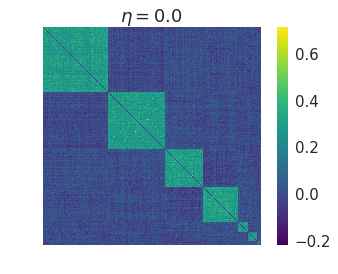

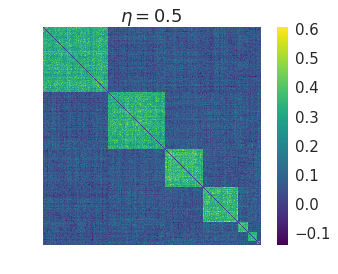

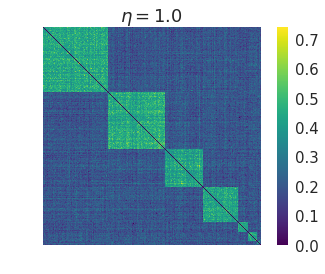

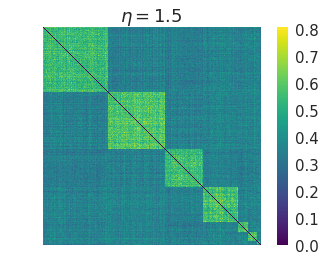

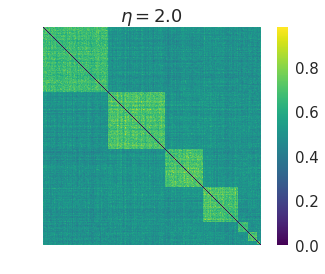

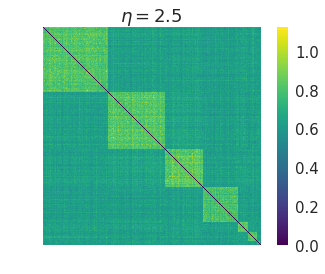

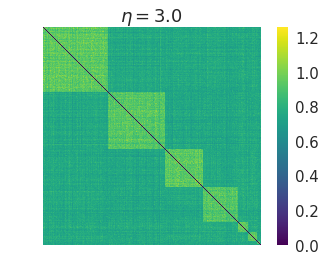

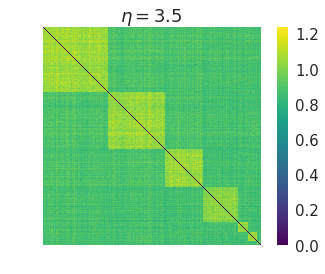

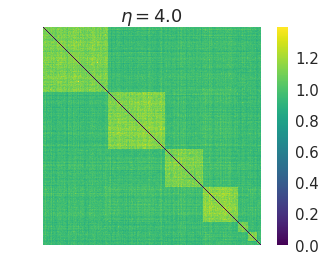

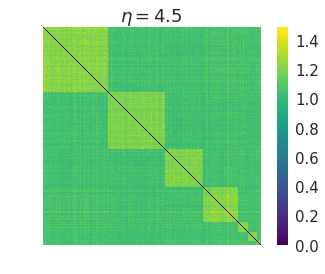

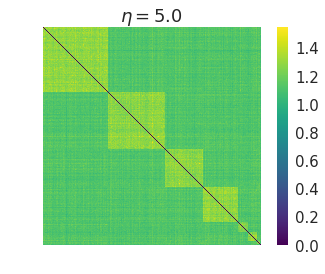

In [10]:
sns.set(font_scale=1.5)
T,local_noise,global_noise,factor=200,2.5,1.5,0.8
beta_range=np.logspace(-3,0,200)
all_global_noise = np.linspace(0,5,11)
cmap = sns.color_palette('viridis',len(all_global_noise))
sns.set_palette('viridis')
for i,g in enumerate(all_global_noise):
    A = np.array([ brain_network(ci=ci, T=200, local_noise=local_noise, global_noise=g, gamma=1, density=1)*factor for x in range(0,10)]).mean(axis=0)
    
    plt.imshow(A[np.ix_(ixes,ixes)],cmap='viridis')
    plt.colorbar()
    plt.axis('off')
    plt.title('$\\eta=%.1f$' % g)
    plt.grid(False)
    plt.show()

#plt.savefig('spectral_entropy_synthetic_global_noise.pdf',dpi=300,bbox_inches='tight')
#plt.show()

In [139]:
def klhistdiv(ci,T, local_noise, global_noise, gamma, density, factor, empirical_hist):
    A = brain_network(ci, T, local_noise, global_noise, gamma, density)*factor
    w = A.flatten()[np.flatnonzero(W.flatten())]
    weights_hist, weights_bins = np.histogram(w,500,density=False)
    plt.plot(empirical_hist)
    plt.plot(weights_hist)
    dkl = entropy(empirical_hist/empirical_hist.sum(), weights_hist/weights_hist.sum())
    print('\r',T, local_noise, global_noise, gamma, density, factor,'-->',dkl,end='')
    return dkl

In [ ]:
weights = W.flatten()[np.flatnonzero(W.flatten())]
weights_hist, weights_bins = np.histogram(weights, 500, density=False)

klhistdiv(ci,T,local_noise=local_noise,global_noise=global_noise,gamma=1,factor=factor,density=1,empirical_hist=weights_hist)
 #brain_network(ci=ci, T=100, local_noise=1.9, global_noise=1, gamma=1, density=1)*0.8
#ranges = (slice(1,4,0.5), slice(1,6,0.5))
#T = 150
#res = scipy.optimize.brute(lambda x : klhistdiv(ci, T, x[0], x[1], 1, 1, 1, weights_hist), ranges=ranges, full_output=False, finish=None)


In [11]:
def percolation_analysis(W,thresholds):
    giant = []
    for t in thresholds:
        Wt = threshold_absolute(W,t)
        memb, sizes = bct.get_components(Wt)
        giant.append(sizes.max())
    return giant

In [ ]:
nt=100
giantW = percolation_analysis(W,np.linspace(0.0,W.max(),nt))
giantA = percolation_analysis(A,np.linspace(0.0,A.max(),nt))
plt.figure(figsize=(24,8))
plt.plot(np.linspace(0.0,W.max(),nt),giantW)
plt.plot(np.linspace(0.0,W.max(),nt),giantA)
plt.xlabel('Threshold')
plt.ylabel('Giant component')
plt.title('Percolation analysis')

# Effect of edge removal from a clique in the spectral entropies peaks

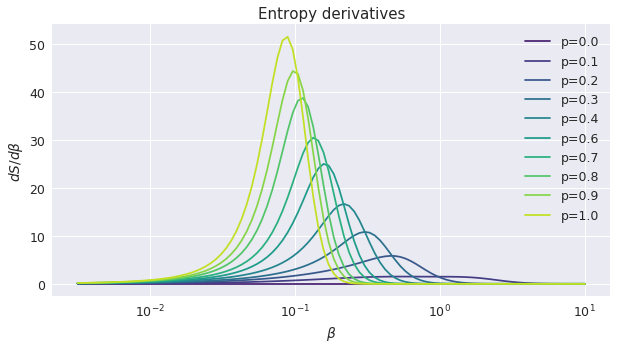

In [64]:
import networkx as nx
import numdifftools as nd
sns.set(font_scale=1.25)
beta_range=np.logspace(-2.5,1,100)
cmap=sns.color_palette('viridis',10)
plt.figure(figsize=(10,5))
for i,dens in enumerate(np.linspace(0,1,10)):
    for reps in range(0,1):
        L=nq.graph_laplacian(nx.to_numpy_array(nx.erdos_renyi_graph(50,dens)))
        dsdb = nd.Derivative(lambda b : nq.compute_vonneumann_entropy(L=L,beta=b))
        plt.semilogx(beta_range,[-dsdb(beta) for beta in beta_range],color=cmap[i])
plt.legend(['p=%.1f'%p for p in np.linspace(0,1,10)])
plt.xlabel('$\\beta$')
plt.ylabel('$dS/d\\beta$')
plt.title('Entropy derivatives')
plt.savefig('entropy_derivative_er.pdf',dpi=150,bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

# Study the spectral entropy as function of internal symmetry

In [12]:
import networkx as nx
def asymmetric_clique(N1,N2):
    G1 = nx.complete_graph(N1)
    G2 = nx.complete_graph(N2)
    G = nx.disjoint_union(G1,G2)
    if not nx.is_empty(G1):
        n1last = (list(G1.nodes())[-1])
        n2last = (list(G2.nodes())[-1])
        G.add_edge(n1last,n1last+1)
    return nx.to_numpy_array(G)

In [48]:
import networkx as nx
def asymmetric_path_clique(N1,N2):
    n0 = 10
    G0 = nx.path_graph(n0)
    G1 = nx.complete_graph(N1)
    G2 = nx.complete_graph(N2)
    G = nx.disjoint_union_all([G0,G1,G2])
    G.add_edge(n0-1,n0)
    G.add_edge(0,n0+N1+N2-1)
    return nx.to_numpy_array(G)

In [69]:
N=30
beta_range = np.logspace(-3,3,50)
vals = range(0,N+2,10)
cmap = sns.color_palette('viridis',len(vals))

IndexError: list index out of range

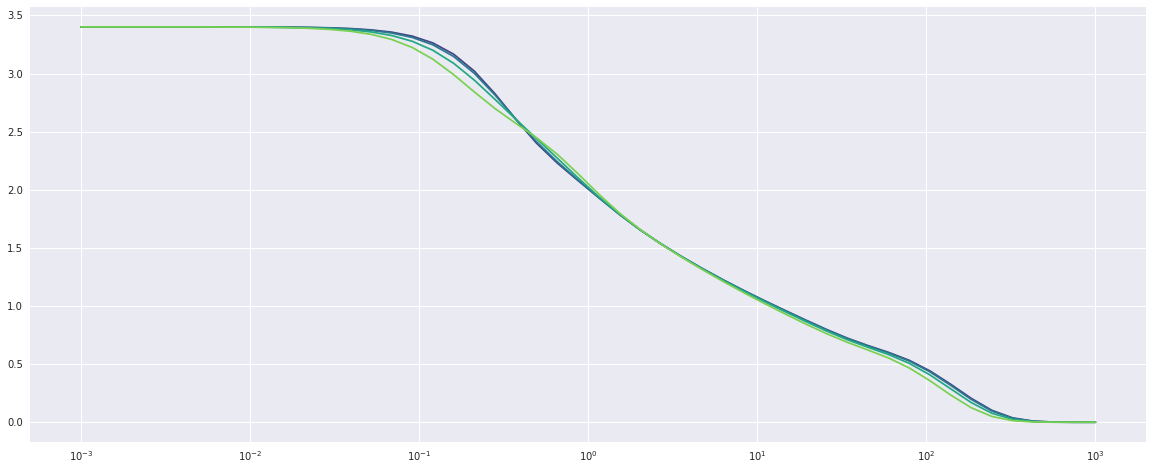

In [68]:
#plt.semilogx(1/beta_range, [nq.compute_vonneumann_entropy(L=nq.graph_laplacian(asymmetric_clique(50,50)),beta=beta) for beta in beta_range])
plt.figure(figsize=(20,8))
vals = range(0,N+2,2)
for i,j in enumerate(vals):
    plt.semilogx(beta_range, [nq.compute_vonneumann_entropy(L=nq.graph_laplacian(asymmetric_path_clique(N-j,N+j)),beta=beta) for beta in beta_range],color=cmap[i])
plt.legend(vals)

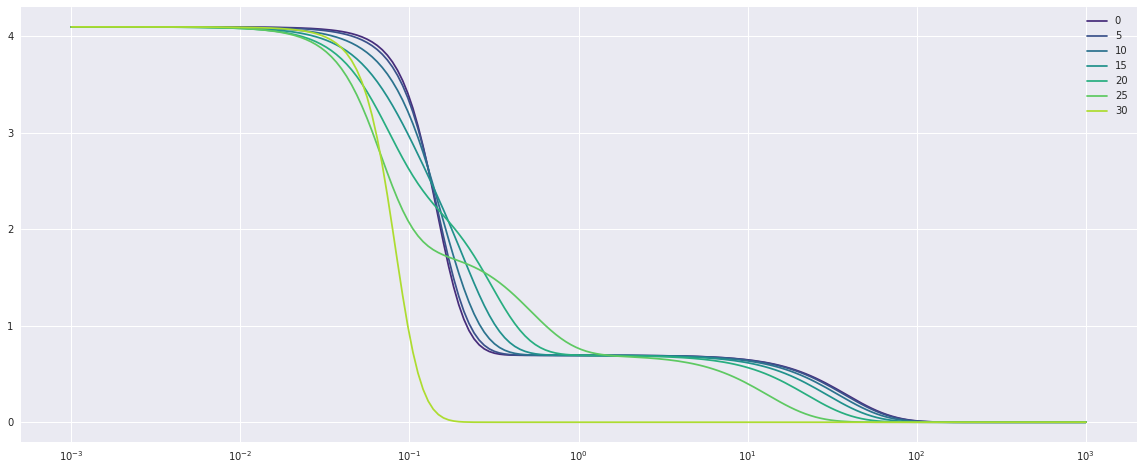

In [21]:
#plt.semilogx(1/beta_range, [nq.compute_vonneumann_entropy(L=nq.graph_laplacian(asymmetric_clique(50,50)),beta=beta) for beta in beta_range])
plt.figure(figsize=(20,8))
for i,j in enumerate(vals):
    plt.semilogx(beta_range, [nq.compute_vonneumann_entropy(L=nq.graph_laplacian(asymmetric_clique(N-j,N+j)),beta=beta) for beta in beta_range],color=cmap[i])
plt.legend(vals)

# Study the derivatives of spectral entropy

<Figure size 2160x576 with 0 Axes>

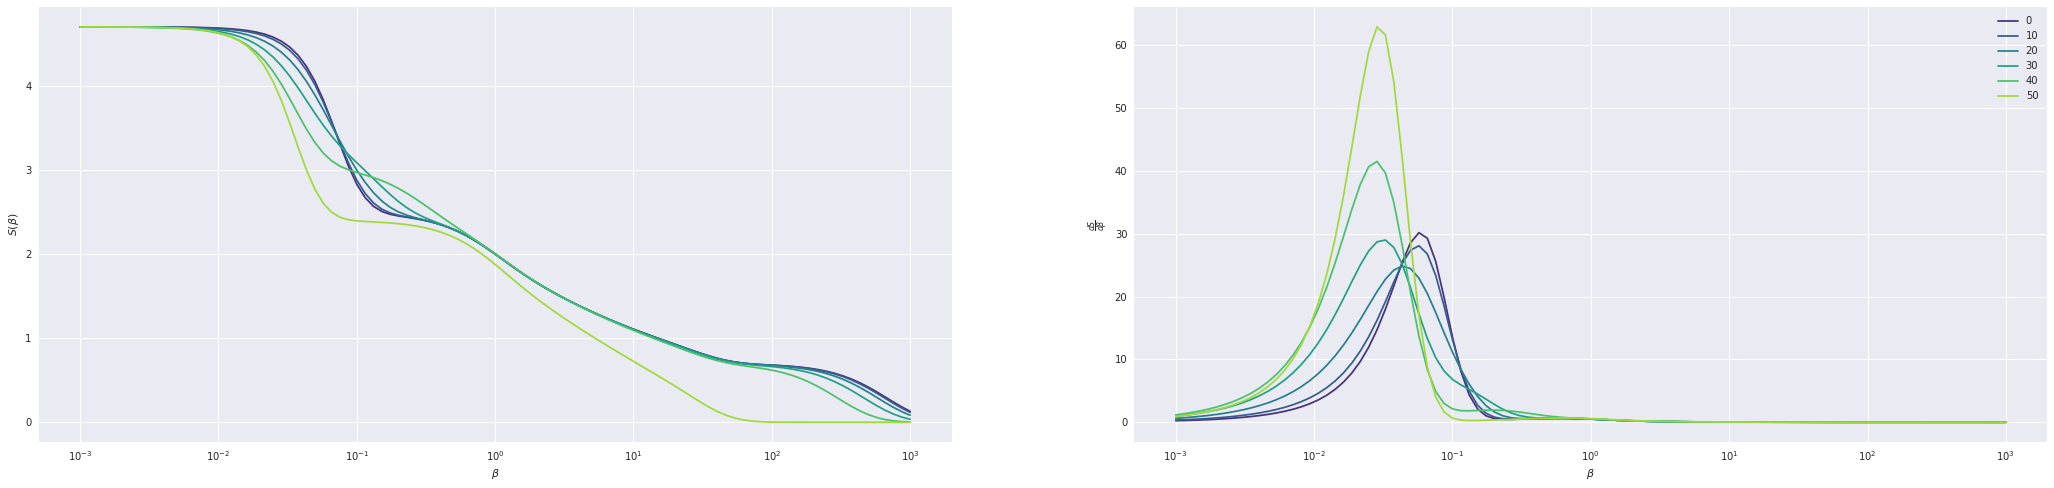

In [75]:
import numdifftools as nd
plt.figure(figsize=(30,8))
N=50
beta_range = np.logspace(-3,3,100)
vals = range(0,N+2,10)
cmap = sns.color_palette('viridis',len(vals))

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(36,8))
for i,j in enumerate(vals):
    ax[0].semilogx(beta_range, [nq.compute_vonneumann_entropy(L=nq.graph_laplacian(asymmetric_path_clique(N-j,N+j)),beta=beta) for beta in beta_range],color=cmap[i])
    ax[0].set_xlabel('$\\beta$')
    ax[0].set_ylabel('$S(\\beta)$')
plt.legend(vals)

for i,j in enumerate(vals):
    Lx = nq.graph_laplacian(asymmetric_path_clique(N-j,N+j))
    dsdb = nd.Derivative(lambda x : nq.compute_vonneumann_entropy(L=Lx,beta=x))
    ax[1].semilogx(beta_range, [-dsdb(beta) for beta in beta_range],color=cmap[i])
    ax[1].set_xlabel('$\\beta$')
    ax[1].set_ylabel('$\\frac{dS}{d\\beta}$')
plt.legend(vals)

## Study the spectral entropy as function of intercluster links density

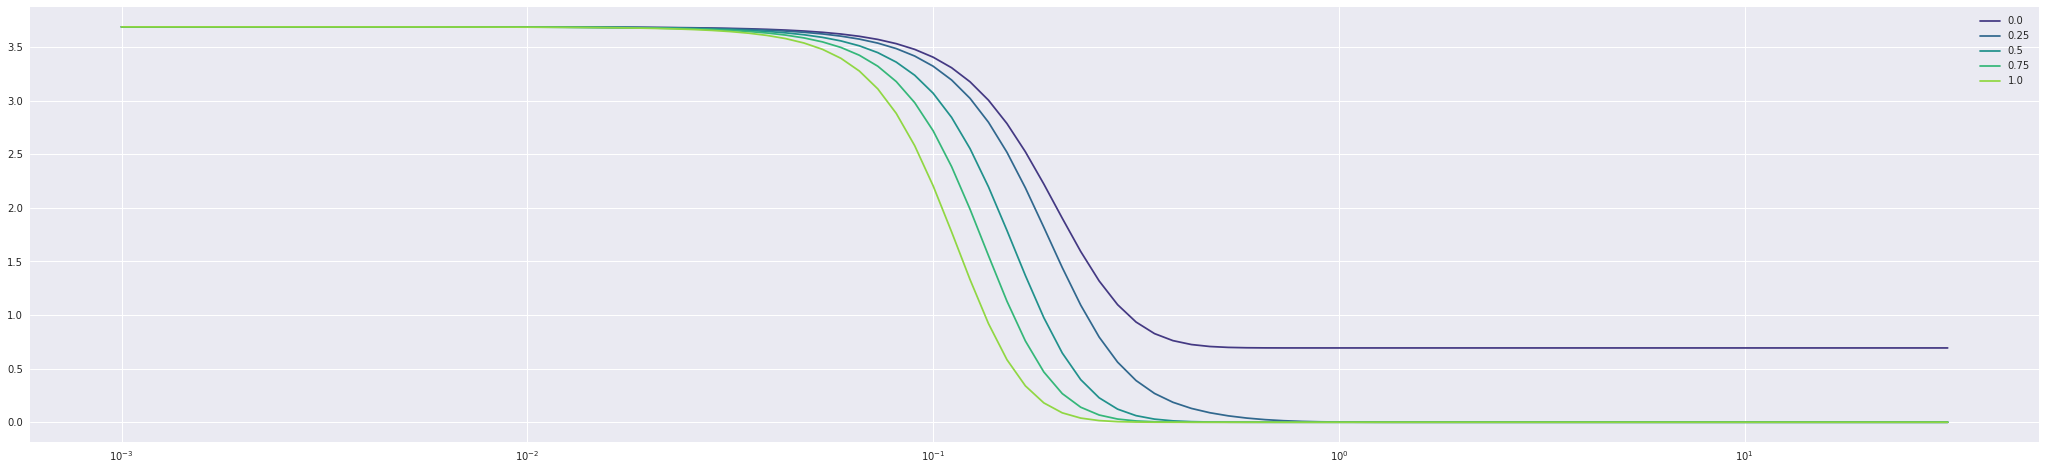

In [88]:
plt.figure(figsize=(36,8))
for i,p_out in enumerate(np.linspace(0,1,5)):
    Lx = nq.graph_laplacian(nx.to_numpy_array(nx.planted_partition_graph(l=2,k=20,p_in=1,p_out=p_out)))
    plt.semilogx(beta_range,[nq.compute_vonneumann_entropy(L=Lx,beta=beta) for beta in beta_range],color=cmap[i])
plt.legend(np.linspace(0,1,5))
plt.show()

### Study the spectral entropy as function of the threshold $\tau$

KeyboardInterrupt: 

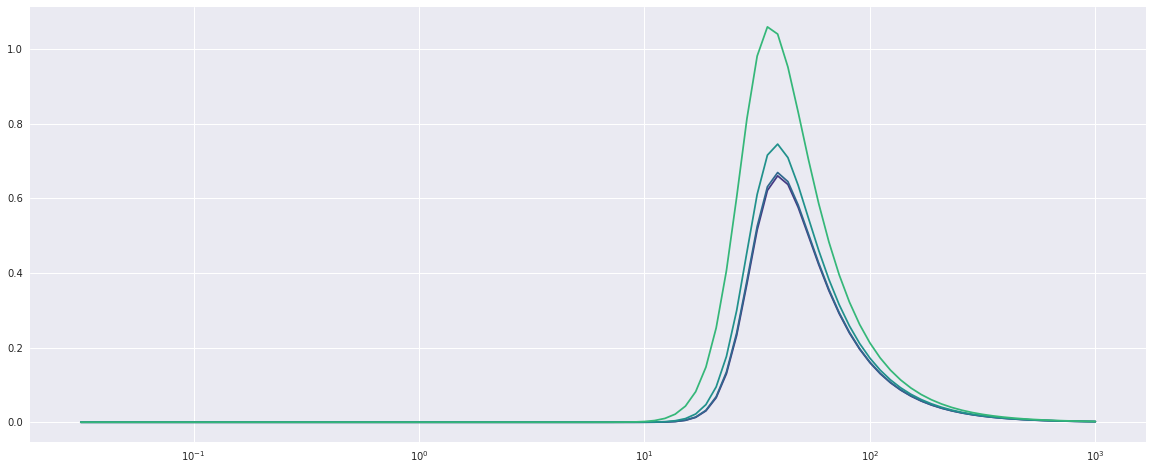

In [80]:
beta_range=np.logspace(-3, 1.5, 100)
cmap = sns.color_palette('viridis', 5)
all_thresh = np.linspace(0,0.25,5)
plt.figure(figsize=(20,8))
for i,t in enumerate(all_thresh):
    plt.semilogx(1/beta_range,np.clip([nq.SpectralDivergence(Lobs=graph_laplacian(threshold_absolute(A,t)),Lmodel=graph_laplacian(threshold_absolute(W,t)),beta=b).rel_entropy 
                                   for b in beta_range ],0,20),color=cmap[i])
plt.xlabel('$1/\\beta$')
plt.legend(all_thresh)
plt.show()

### Plot until one connected component

In [ ]:
def percolation_threshold(A):
    w = np.unique((A*(A>0).astype(float)).flatten())
    iw = range(0,len(w))
    i_perc = np.where(np.array([len(get_components(threshold_absolute(A,t))[1]) for t in w]) > 1)
    return i_perc[0][0], w[i_perc][0]

In [ ]:
i_perc,w_perc = percolation_threshold(A)
print(i_perc,w_perc)